In [20]:
import csv
import re

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
from collections import defaultdict
from pybedtools import BedTool

In [23]:
from tqdm import tqdm

In [24]:
candidates = set()

In [25]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        p, meta_exon, p, ss,  _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row
        
        if int(tree_size) < 3 or ";" in gain_ages:
            # `";" in gain_events` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon_type != "FE":
            continue

        if "homo_sapiens" in pos_group \
                and "mus_musculus" in neg_group:
            # H. sap. gained an FE SS and M. mus did not. I then
            # check whether the FE has an annotated homolog in the
            # mouse genome, i.e., to infer cases where the whole
            # exon might've been gained, versus just the SS.
            candidates.add(exon)

In [26]:
stat_cand = {'new_fe': str(), 'new_ss': str()}

In [27]:
with open("../data/homology/exons/hsap_mmus.csv", 'r') as f:
    reader = csv.reader(f)
    
    for row in reader:
        hsap_exon, hsap_type, mmus_exon, mmus_type = row
        
        if hsap_exon in candidates:
            chrom, *pos = re.split('[:-]', mmus_exon)
            
            beg, end, strand = map(int, pos)
            strand = "+" if strand else "-"
            
            match mmus_type:
                case "NE":
                    stat = 'new_fe'
                case "FE": 
                    stat = 'new_ss'
                case _:
                    continue

            # ENCODE uses GENCODE, so we need to add the "chr" prefix.
            stat_cand[stat] += (
                f"chr{chrom}\t"
                f"{beg}\t"
                f"{end}\t"
                f".\t"
                f"0\t"
                f"{strand}\n")

In [28]:
new_fe_bed = BedTool(stat_cand['new_fe'], from_string=True).sort()
new_ss_bed = BedTool(stat_cand['new_ss'], from_string=True).sort()

In [29]:
new_fe_bed.saveas("data/homology/exons/hsap_fe_neg_for_homolog_in_mmus.bed")
new_ss_bed.saveas("data/homology/exons/hsap_fe_pos_for_homolog_in_mmus.bed")

<BedTool(data/homology/exons/hsap_fe_pos_for_homolog_in_mmus.bed)>

In [30]:
cre_bed = BedTool("data/screen/mmus.bed")
cre_background = defaultdict(lambda: 0)

In [31]:
for *_, cre in cre_bed:
    cre_background[cre] += 1

In [32]:
t = sum(cre_background.values())
cre_background = {cre: N / t for cre, N in cre_background.items()}

In [33]:
new_fe_cre_bed = new_fe_bed.intersect(cre_bed, wao=True)
new_ss_cre_bed = new_ss_bed.intersect(cre_bed, wao=True)

In [35]:
long_data = list()

In [36]:
for name, bed in zip("pn", [new_fe_cre_bed, new_ss_cre_bed]):
    count = defaultdict(lambda: 0)
    exons = set()

    for row in bed:
        pos = tuple(row[:6])
        cre = tuple(row[6:])
        
        exons.add(pos)
        
        if cre[-2] != ".":
            count[cre[-2]] += 1

    t = sum(count.values())
    d = {n: count[n] / t for n in count}
    
    for cre, new_percent  in d.items():
        bg_percent = cre_background[cre]
        
        long_data.append({
            'cat': name,
            'cre': cre,
            'enrichment': np.log2(new_percent / bg_percent)
        })

In [37]:
frame = pd.DataFrame(long_data)
x_order = sorted(cre_background.keys())

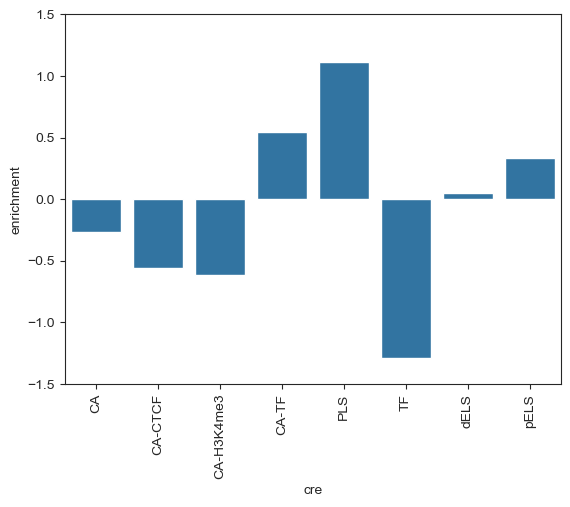

In [38]:
sns.set_style('ticks')
sns.barplot(frame[frame['cat'] == "p"], x='cre', y='enrichment', order=x_order)

plt.xticks(rotation=90)

plt.ylim(-1.5, 1.5)
plt.savefig("figs/main4b.pdf")